## Edge Processing
In this lab, we will learn to utilize edge information to extract useful "things" from images. This notebook includes both coding and written questions. Please hand in this notebook file with all outputs and your answer

Import OpenCV, Numpy and Matplotlib as always

In [15]:
import cv2
import math
import numpy as np
import random as rng
from matplotlib import pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets
import urllib.request
%matplotlib inline

Use <a href="https://docs.opencv.org/3.4.1/d4/da8/group__imgcodecs.html#ga288b8b3da0892bd651fce07b3bbd3a56">imread</a> function to read image from file. Since edge detection functions <b>require</b> a single channel input image, we must convert the input image into grayscale by using <a href="https://docs.opencv.org/3.4.1/d7/d1b/group__imgproc__misc.html#ga397ae87e1288a81d2363b61574eb8cab">cvtColor</a>.

inputImage dimensions (323, 300, 3)


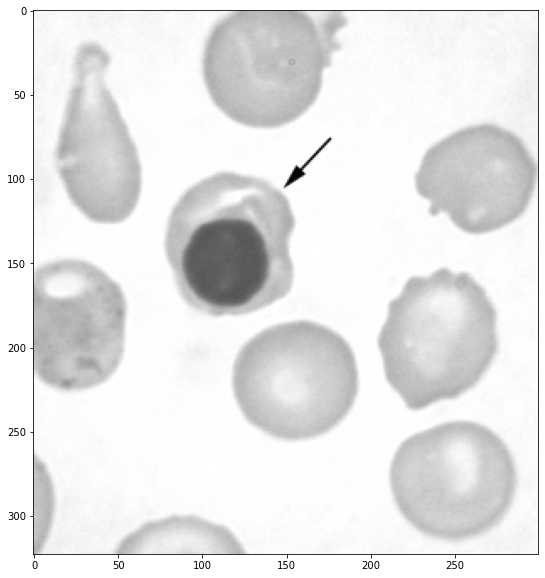

In [17]:
inputImage = cv2.imread("assets/Lab3-rbc.jpg")
print('inputImage dimensions', inputImage.shape)
inputImageGray = cv2.cvtColor(inputImage,cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(10,10))
plt.imshow(inputImageGray,cmap = 'gray')
plt.show()

## Edge Detection

Edge detection is one of the fundamental operations in image processing and computer vision, including object detectors and image segmentation algorithms. It helps us reduce the amount of data  to process while still maintains the structural/shape representation of the image. OpenCV already implemented some famous edge detector. In this section, we will apply well-known edge detector on the provided image.

### 1.Sobel Edge Detector
Sobel edge detector is a gradient based method based on the first order derivatives. It separately calculates the first derivatives for the X and Y axes. You can use it by calling <a href="https://docs.opencv.org/3.4.2/d4/d86/group__imgproc__filter.html#gacea54f142e81b6758cb6f375ce782c8d">cv2.Sobel</a>

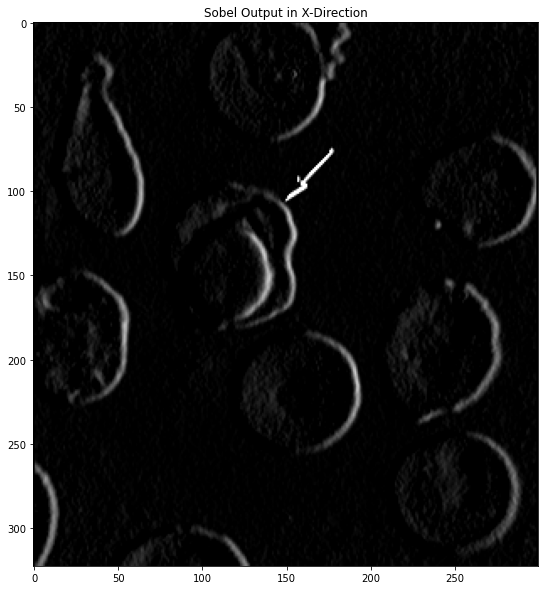

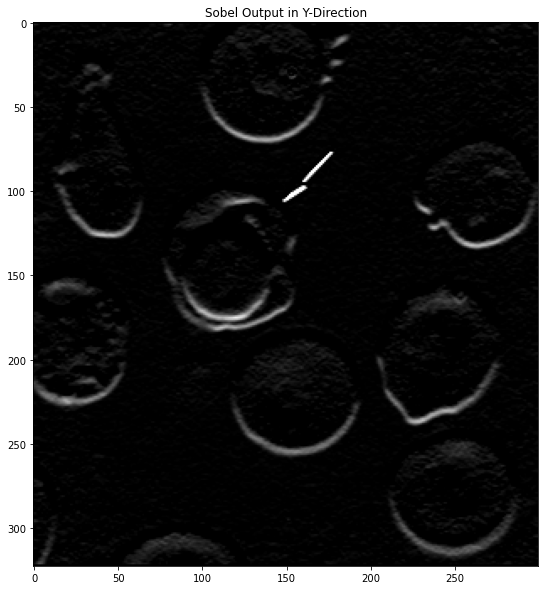

In [18]:
sobelXOutput = cv2.Sobel(inputImageGray,cv2.CV_8U,1,0,ksize=3) # CV_8U is unsigned 8bit/pixel - ie a pixel can have values 0-255, this is the normal range for most image and video formats.
sobelYOutput = cv2.Sobel(inputImageGray,cv2.CV_8U,0,1,ksize=3)
plt.figure(figsize=(10,10))
plt.title('Sobel Output in X-Direction')
plt.imshow(sobelXOutput, cmap='gray')
plt.figure(figsize=(10,10))
plt.title('Sobel Output in Y-Direction')
plt.imshow(sobelYOutput, cmap='gray')
plt.show()

#### <b>Remark</b>
There is a slight problem with both outputs because of their data type. Since black-to-white transition is taken as positive slope (positive value) while white-to-black is taken as a negative slope (negative value), uint8 data type is only capable for positive value. When you convert data to np.uint8, all negative slopes are considered as zero and some edges will be missed. To overcome this problem we will apply absolute operator before convert into np.uint8

float64


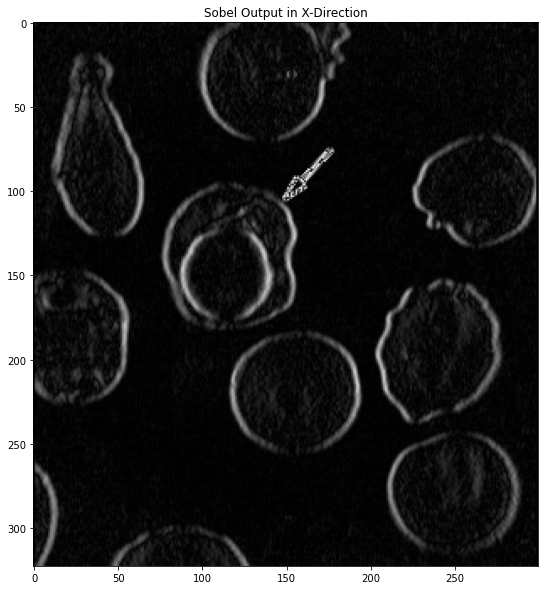

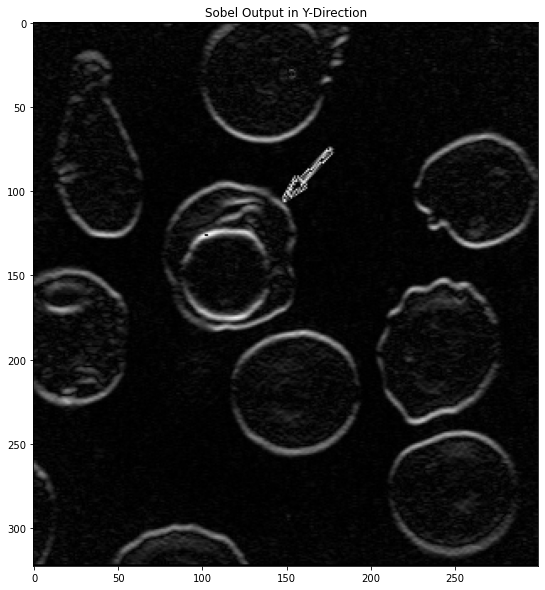

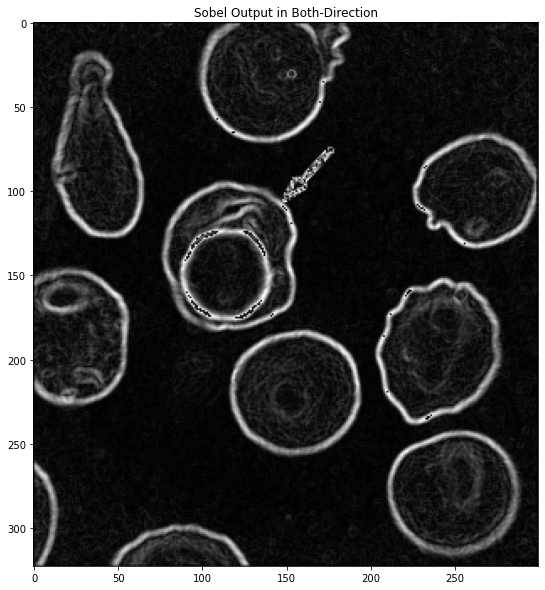

In [19]:
sobelXOutput_64F = cv2.Sobel(inputImageGray,cv2.CV_64F,1,0,ksize=3)  # first, apply with Float64
print(sobelXOutput_64F.dtype)
sobelXOutput_64F = np.uint8(np.absolute(sobelXOutput_64F))
sobelYOutput_64F = cv2.Sobel(inputImageGray,cv2.CV_64F,0,1,ksize=3)
sobelYOutput_64F = np.uint8(np.absolute(sobelYOutput_64F))
plt.figure(figsize=(10,10))
plt.title('Sobel Output in X-Direction')
plt.imshow(sobelXOutput_64F, cmap='gray')
plt.figure(figsize=(10,10))
plt.title('Sobel Output in Y-Direction')
plt.imshow(sobelYOutput_64F, cmap='gray')
plt.show()
plt.figure(figsize=(10,10))
plt.title('Sobel Output in Both-Direction')
plt.imshow(sobelXOutput_64F + sobelYOutput_64F, cmap='gray')  # X_edge + Y_edge
plt.show()

### 2.Robert Edge Detector
Use the knowledge from lecture section 🤔 and <b>your own</b> myFilter2D function from Lab 2 - Assignment3 to built Robert edge detector! Compare the result with original OpenCV <a href="https://docs.opencv.org/3.4.2/d4/d86/group__imgproc__filter.html#ga27c049795ce870216ddfb366086b5a04">cv2.filter2D</a>.

In [20]:
#### Your filter2D function! ####
def myFilter2D(inputImage, kernel, paddingMethod="constant", paddingValue=0):
    def filtering(img, kernel):   
        w,h = img.shape; strides = (w,1,h,1)
        kw,kh = kernel.shape
        view_shape =  (w-kw+1,h-kh+1)+(kw,kh)
        sub_matrices = np.lib.stride_tricks.as_strided(img,view_shape,strides) # sub_matrices for each stride
        print(sub_matrices.shape)
        filtered_img = np.array(np.clip(np.einsum('ij,klij->kl',kernel,sub_matrices),0,255 ),np.uint8)  # preventing overflow
        return filtered_img
    def two_s_filter(img,kernel):
        # manual zero-padding 
        base = np.vstack((img, np.zeros((1,img.shape[1]))))
        base = np.hstack((img, np.zeros((img.shape[0],1))))
        w,h = img.shape
        result = np.zeros(img.shape)
        for i in range(w):
            for j in range(h):
                result[i,j] = np.sum(np.multiply(kernel,base[i:i+2,j:j+2]))
        return np.array(np.clip(result,0,255),np.uint8)
    if kernel.shape == (2,2):  return two_s_filter(inputImage,kernel)
    padding_size = int((kernel.shape[0]-1)/2)   
    # padding Value
    if paddingMethod == "constant": padded_img = np.pad(inputImage, (padding_size,padding_size), constant_values = paddingValue)    
    # use edge
    elif paddingMethod == "replicate": padded_img = np.pad(inputImage, (padding_size,padding_size), mode='edge')  
    # non-padding 
    elif paddingMethod == "valid": padded_img = inputImage.copy()
    else:
        print("Invalid padding method")
        return None
    return filtering(padded_img,kernel)

In [21]:
#### FILL HERE ####
def robert(img,openCV,x,y):
    if not (x or y): return img 
    rox = np.array([[0,1],[-1,0]]); roy = np.array([[1,0],[0,-1]])
    result = np.zeros(img.shape)
    if openCV:
        if x: result += cv2.filter2D(img,-1,rox)
        if y: result += cv2.filter2D(img,-1,roy) 
    else:
        if x: result += myFilter2D(img,rox) #result += myFilter2D(img,rox)
        if y: result += myFilter2D(img,roy) #result += myFilter2D(img,roy)
    return result 
####

In [22]:
def plot_img(img,title):
    plt.figure(figsize=(10,10))
    plt.title(title)
    plt.imshow(img, cmap='gray')
    plt.show()

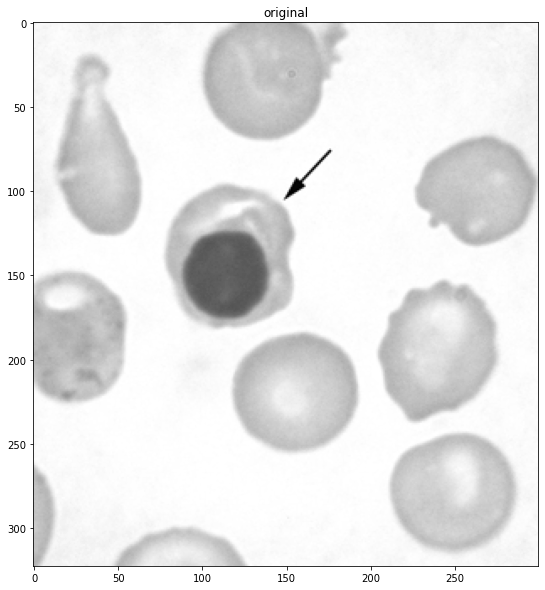

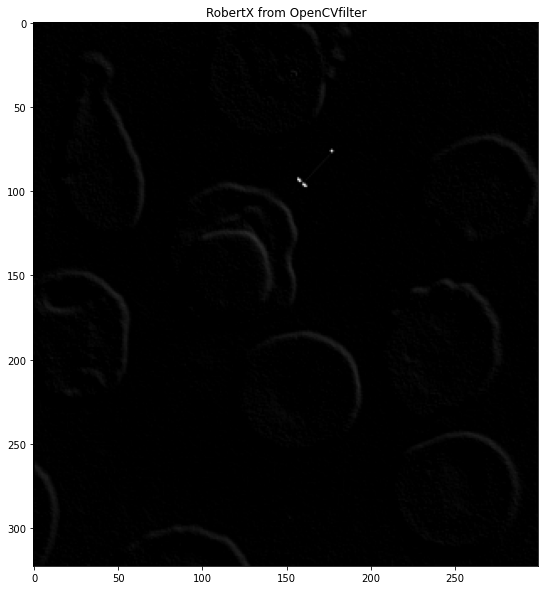

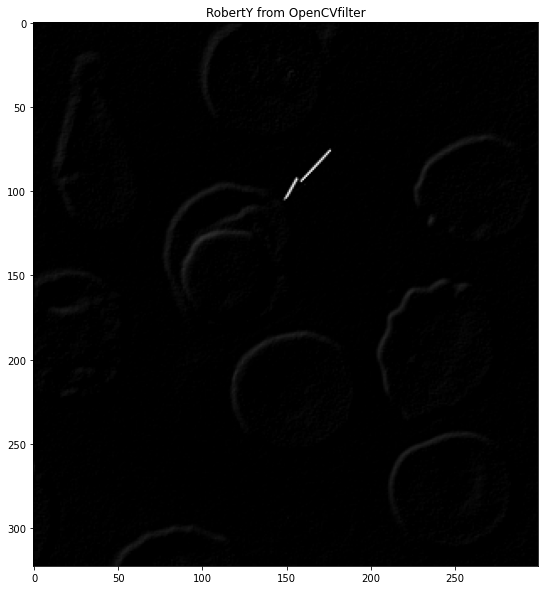

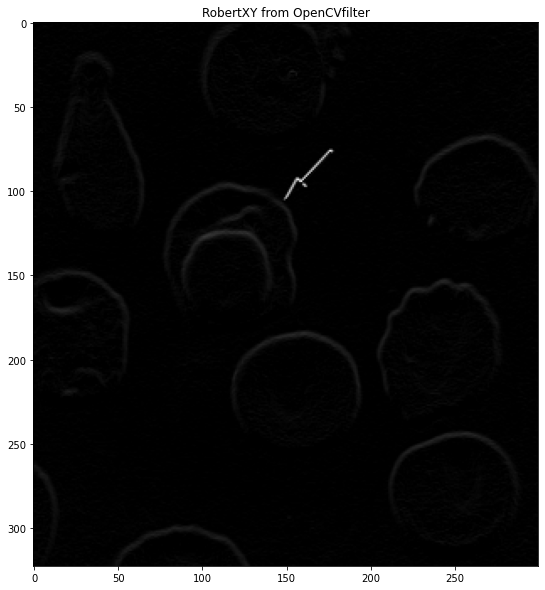

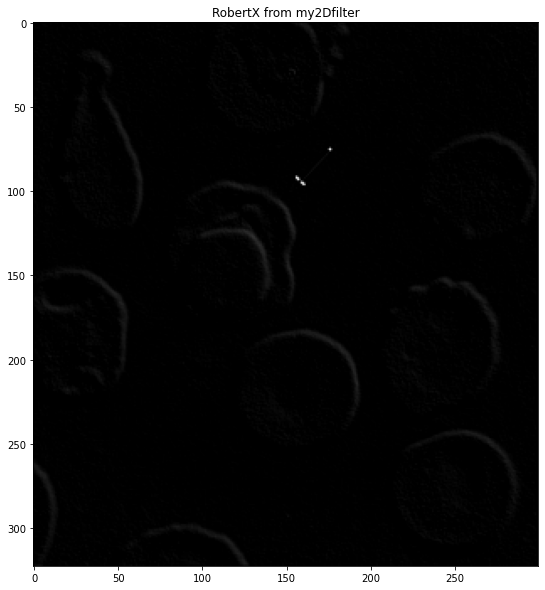

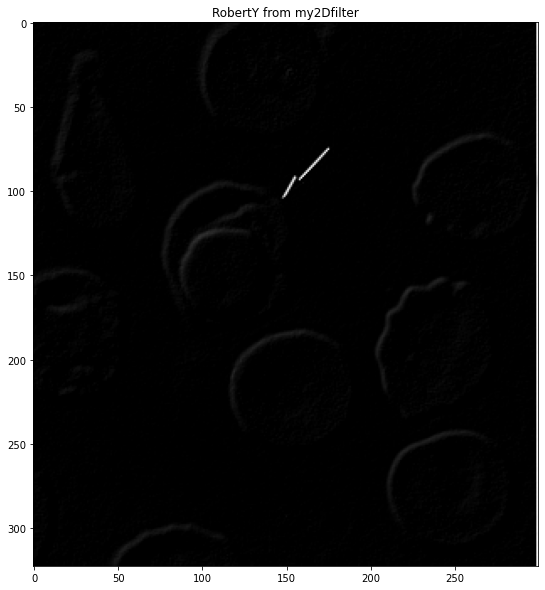

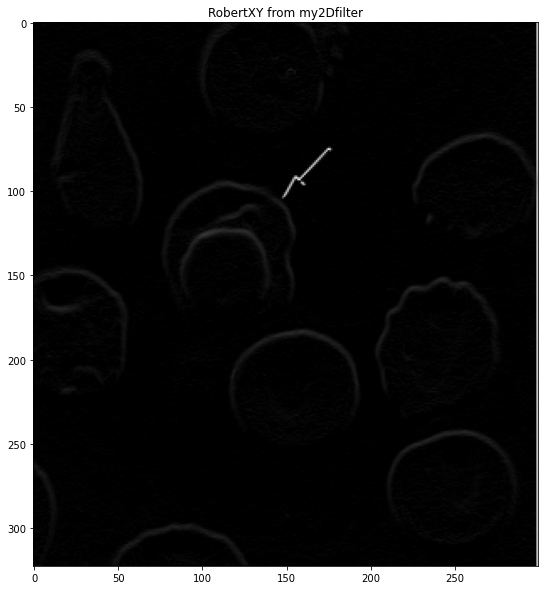

In [23]:
inputImageGray = cv2.cvtColor(inputImage,cv2.COLOR_BGR2GRAY)
plot_img(inputImageGray,'original')
plot_img(robert(inputImageGray,openCV=True,x=True,y=False),  'RobertX from OpenCVfilter')
plot_img(robert(inputImageGray,openCV=True,x=False,y=True),  'RobertY from OpenCVfilter')
plot_img(robert(inputImageGray,openCV=True,x=True,y=True),  'RobertXY from OpenCVfilter')
plot_img(robert(inputImageGray,openCV=False,x=True,y=False), 'RobertX from my2Dfilter')
plot_img(robert(inputImageGray,openCV=False,x=False,y=True), 'RobertY from my2Dfilter')
plot_img(robert(inputImageGray,openCV=False,x=True,y=True),  'RobertXY from my2Dfilter')

### 3. Laplacian
Laplacian filter is an edge detector used to compute the second derivatives of an image

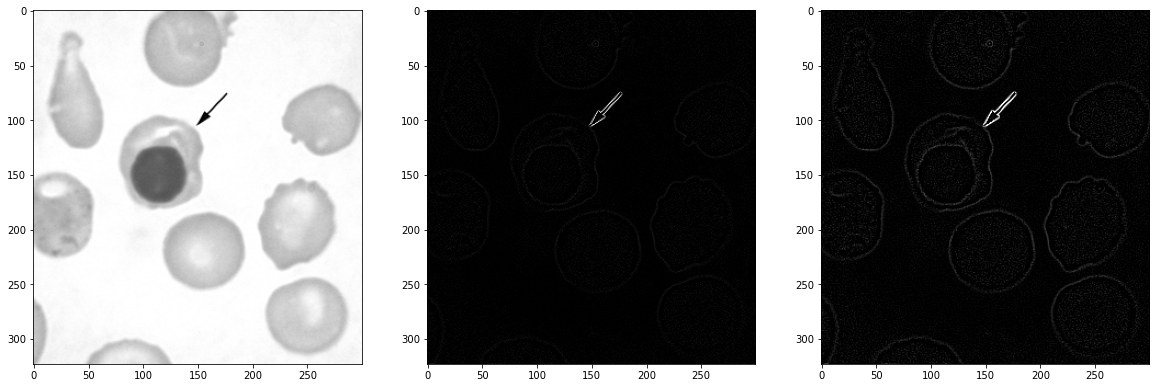

In [24]:
laplacianKernel_1 = np.array([[0,-1,0], [-1,4,-1], [0,-1,0]])
laplacianKernel_2 = np.array([[-1,-1,-1], [-1,8,-1], [-1,-1,-1]])

inputImageGray = cv2.cvtColor(inputImage, cv2.COLOR_BGR2GRAY)
laplacianOutput_1 = cv2.filter2D(inputImageGray, -1, laplacianKernel_1)
laplacianOutput_2 = cv2.filter2D(inputImageGray, -1, laplacianKernel_2)

plt.figure(figsize=(20,20))
plt.subplot(1,3,1)
plt.imshow(inputImageGray, cmap='gray')
plt.subplot(1,3,2)
plt.imshow(laplacianOutput_1, cmap='gray')
plt.subplot(1,3,3)
plt.imshow(laplacianOutput_2, cmap='gray')
plt.show()

#### a. Image Sharpening

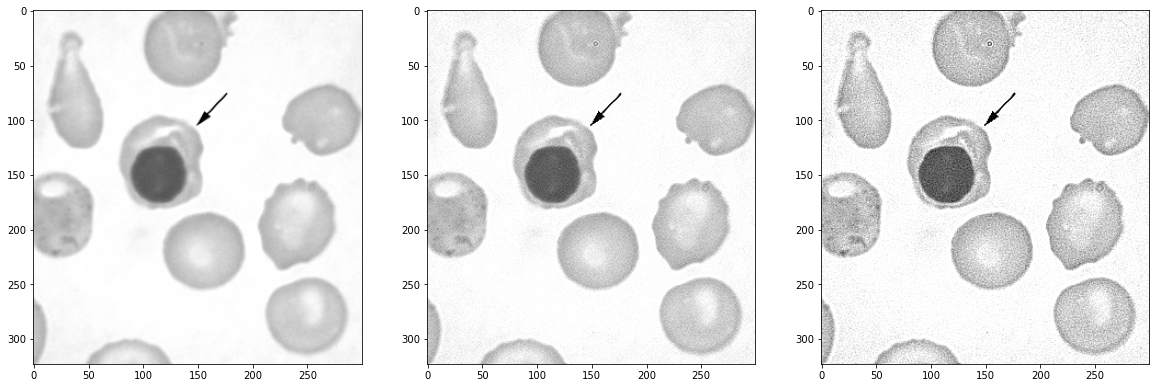

In [25]:
sharpenKernel_1 = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])
sharpenKernel_2 = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])

inputImageGray = cv2.cvtColor(inputImage, cv2.COLOR_BGR2GRAY)
sharpenOutput_1 = cv2.filter2D(inputImageGray, -1, sharpenKernel_1)
sharpenOutput_2 = cv2.filter2D(inputImageGray, -1, sharpenKernel_2)
plt.figure(figsize=(20,20))
plt.subplot(1,3,1)
plt.imshow(inputImageGray, cmap='gray')
plt.subplot(1,3,2)
plt.imshow(sharpenOutput_1, cmap='gray')
plt.subplot(1,3,3)
plt.imshow(sharpenOutput_2, cmap='gray')
plt.show()

### 4.Canny Edge Detector
Canny edge detector is a popular edge detection algorithm. It is a multi-stages algorithm based on Sobel edge detector and is considered to give a better result. You can read <a href="https://docs.opencv.org/3.4.2/da/d22/tutorial_py_canny.html">here</a> for short summary of this algorithm. You can Canny edge detector by calling <a href="https://docs.opencv.org/3.4.2/dd/d1a/group__imgproc__feature.html#ga04723e007ed888ddf11d9ba04e2232de">cv2.Canny</a>


In [26]:
# Use ipywidgets and interact function to see the result of Canny edge detctor by yourself.
#### FILL HERE ####
from ipywidgets import interact
def canny(th1,th2):
    canny_img = cv2.Canny(inputImageGray,th1,th2)
    plt.figure(figsize=(5,5))
    plt.imshow(canny_img, cmap='gray')
    plt.show()
interact(canny, th1=widgets.IntSlider(min=0,max=255,step=1,value=0),th2=widgets.IntSlider(min=0,max=255,step=1,value=0));
####

interactive(children=(IntSlider(value=0, description='th1', max=255), IntSlider(value=0, description='th2', ma…

### 5. Structured Edge Detector
[Bonus] The gradient based edge detectors are typically susceptible to noise in the image and it is difficult to overcome this problem by using traditional pixel features. Instead of finding suitable rule-based methods for each task, a learning based edge detector named "Structured Edge" was proposed by Microsoft researcher team in International Conference on Computer Vision 2013 (ICCV2013). This algorithm use random forest to give each pixel edge intensity value based on locality feature. You can read their paper <a href="https://www.microsoft.com/en-us/research/wp-content/uploads/2013/12/DollarICCV13edges.pdf">here</a>.

In [30]:
# Grab edge model file from opencv_contrib repository
urllib.request.urlretrieve('https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/cv/ximgproc/model.yml.gz', 'assets/structuredEdgeModel.yml.gz')

('assets/structuredEdgeModel.yml.gz', <http.client.HTTPMessage at 0x1864d18e0>)

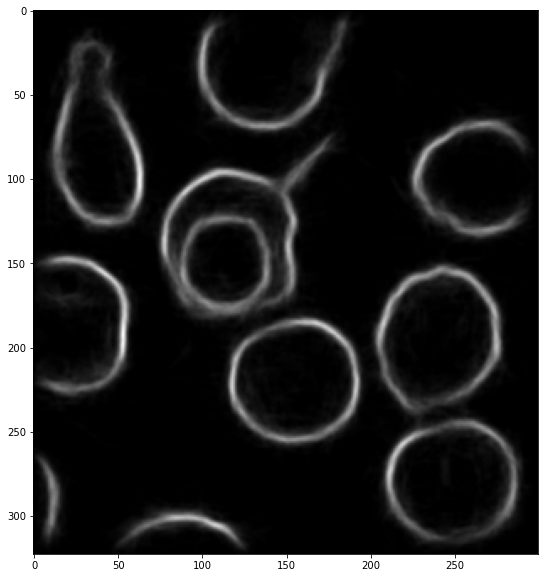

In [31]:
# Structured Edge Detector requires input to be in RGB order
# Microsoft paper: random forest edge detector 
structuredEdgeDetector = cv2.ximgproc.createStructuredEdgeDetection('assets/structuredEdgeModel.yml.gz')
inputImageRGB = cv2.cvtColor(inputImage, cv2.COLOR_BGR2RGB)
structuredEdgeOutput = np.uint8(structuredEdgeDetector.detectEdges(np.float32(inputImageRGB) / 255.0)*255)
plt.figure(figsize=(10,10))
plt.imshow(structuredEdgeOutput, cmap='gray')
plt.show()

### 6. Holistically-Nested Edge Detection (HED)
[Bonus] As mentioned in previous method, the pioneer gradient based methods are typically susceptible to noise in the image difficult to overcome this problem by using traditional pixel features. Holistically-Nested Edge Detection (HED) was proposed in International Conference on Computer Vision 2015 (ICCV2015) , attempts to address the limitations of the feature based edge detector through an fully convolutional neural network structure. You can read their paper <a href="https://arxiv.org/abs/1504.06375">here</a>

In [32]:
# Grab HED model file from author repository
urllib.request.urlretrieve('http://vcl.ucsd.edu/hed/hed_pretrained_bsds.caffemodel', 'assets/hed_pretrained_bsds.caffemodel')
urllib.request.urlretrieve('https://raw.githubusercontent.com/s9xie/hed/master/examples/hed/deploy.prototxt', 'assets/deploy.prototxt')

('assets/deploy.prototxt', <http.client.HTTPMessage at 0x186129940>)

In [33]:
class CropLayer(object):
    def __init__(self, params, blobs):
        self.xstart = 0
        self.xend = 0
        self.ystart = 0
        self.yend = 0
        
    def getMemoryShapes(self, inputs):
        inputShape, targetShape = inputs[0], inputs[1]
        batchSize, numChannels = inputShape[0], inputShape[1]
        height, width = targetShape[2], targetShape[3]

        self.ystart = (inputShape[2] - targetShape[2]) // 2
        self.xstart = (inputShape[3] - targetShape[3]) // 2
        self.yend = self.ystart + height
        self.xend = self.xstart + width

        return [[batchSize, numChannels, height, width]]

    def forward(self, inputs):
        return [inputs[0][:,:,self.ystart:self.yend,self.xstart:self.xend]]

cv2.dnn_registerLayer('Crop', CropLayer)

hedNet = cv2.dnn.readNet('assets/hed_pretrained_bsds.caffemodel', 'assets/deploy.prototxt')

In [34]:
inputTensor = cv2.dnn.blobFromImage(inputImage, scalefactor=1.0, size=inputImage.shape[0:2], mean=(104.00698793, 116.66876762, 122.67891434), swapRB=True, crop=False)
hedNet.setInput(inputTensor)
hedNetOutput = cv2.resize(hedNet.forward().squeeze(), inputImage.shape[0:2])

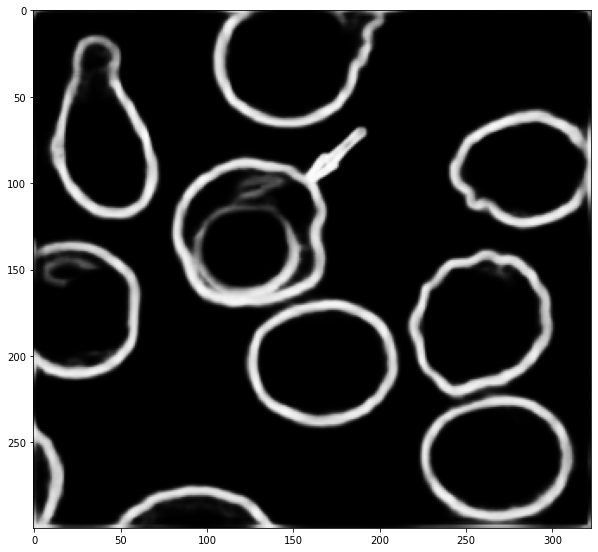

In [35]:
plt.figure(figsize=(10,10))
plt.imshow(hedNetOutput, cmap='gray')
plt.show()

## Extract the objects (Red Blood Cells) using edge information

Using both X-Y Sobel edge output and apply simple threshold to keep only strong edge

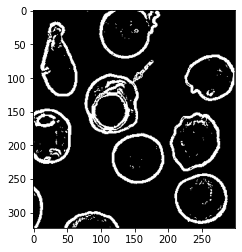

In [36]:
sobelXYOutput = sobelXOutput_64F + sobelYOutput_64F
sobelXYOutput = np.uint8(sobelXYOutput > 60)
plt.imshow(sobelXYOutput, cmap='gray')
plt.show()

Categorize each strong edge pixel into contours by using <a href="https://docs.opencv.org/4.5.1/d3/dc0/group__imgproc__shape.html#gae4156f04053c44f886e387cff0ef6e08">cv2.findContour</a>

In [37]:
rbcContours, _ = cv2.findContours(sobelXYOutput, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

Colorize each contour by using <a href="https://docs.opencv.org/3.4.2/d6/d6e/group__imgproc__draw.html#ga746c0625f1781f1ffc9056259103edbc">cv2.drawContour</a>. You will see that there are some <b>noise</b> contours appear.

Total Red Blood Cell: 72


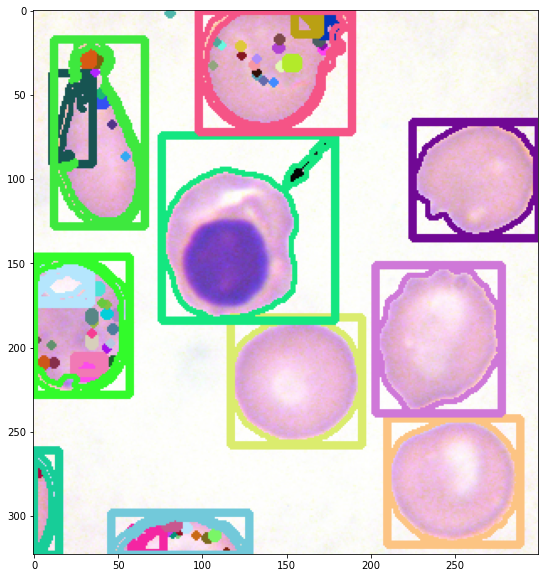

In [38]:
rbcContourImage = inputImage.copy()
for rcbContourIdx in range(len(rbcContours)):
    color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
    # Calculates the bounding rectangle of a contour
    x, y, w, h = cv2.boundingRect(rbcContours[rcbContourIdx])
    cv2.drawContours(rbcContourImage, rbcContours, rcbContourIdx, color, 2)
    cv2.rectangle(rbcContourImage,(x,y),(x+w,y+h),color,3)
rbcContourImage = cv2.cvtColor(rbcContourImage,cv2.COLOR_BGR2RGB)
print('Total Red Blood Cell:',len(rbcContours))
plt.figure(figsize=(10,10))
plt.imshow(rbcContourImage)
plt.show()

## Improved Simple RBC Detector
Is there anyway to improve the rcb detection quality? Why you do that? You can use the knowledge from previous and this lecture to answer this question! Implement your own modifiation in the following block and display the output for <b>both Lab3-rbc.jpg and Lab3-rbc2.jpg</b>.

In [39]:
import cv2

# Note: most of the technniques that I have used in Assignment are learn from the Digital Image processing class. 

def plot_img(img,cmap,title):
  if cmap == 'gray': plt.imshow(img,cmap=cmap)
  else: plt.imshow(img)
  plt.title(title)
  plt.show()

def rbc_counter( dilate_kernel,dilate_iterations=5, fg_fractional=0.1, area_thres = 10 , visualize=True):
    img = cv2.imread("assets/Lab3-rbc.jpg")
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(img,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU) # OTSU_thresholding
    kernel  = np.ones(dilate_kernel,np.uint8) # dilate kernel
    dilated = cv2.dilate(thresh, kernel, iterations=dilate_iterations) # dilation
    distance  = cv2.distanceTransform(dilated,cv2.DIST_L2,5) #distancing
    fraction_foreground = fg_fractional # fg
    _, fg = cv2.threshold(distance,fraction_foreground*distance.max(),255,0) # fg_threshold
#     _, cc = cv2.connectedComponents(fg.astype(np.uint8)) # connected_component
    connectivity = 4
    output = cv2.connectedComponentsWithStats(fg.astype(np.uint8), connectivity, cv2.CV_32S)
    num_labels = output[0]
    labels = output[1]
    stats = output[2]
    centroids = output[3]
    # filter_small_area()
    filtered_list = [] 
    for i in range(1,num_labels):
        if  stats[i, cv2.CC_STAT_AREA] < area_thres : filtered_list.append(i)
    w,h = labels.shape
    filtered_labels = np.zeros(labels.shape)
    for i in range(w):
        for j in range(h):
            filtered_labels[i][j] = labels[i][j] if labels[i][j] not in filtered_list else 0
            
    markers = filtered_labels+1
    subtracted = cv2.subtract(dilated,fg.astype(np.uint8)) # fg_subtraction
    markers[subtracted==np.max(subtracted)] = 0 #set subtracted_region to zero
    from skimage.segmentation import watershed # https://scikit-image.org/docs/dev/api/skimage.segmentation.html#skimage.segmentation.watershed
    # skimage.segmentation.watershed(image, markers=None, connectivity=1, offset=None, mask=None, compactness=0, watershed_line=False)
    watershedx = watershed(-distance,markers,watershed_line=False) # watershed ,If watershed_line is True, a one-pixel wide line separates the regions obtained by the watershed algorithm. The line has the label 0.

    # plot images for visualization
    if visualize:
        plot_img(img,'gray','input_img')
        plot_img(thresh,'gray','thresholded')
        plot_img(dilated,'gray','dilated')
        plot_img(distance,'gray','distance')
        plot_img(fg,'gray','foreground')
        plot_img(subtracted,'gray','subtracted')
        plot_img(labels,'rgb','connected_components')
        plot_img(filtered_labels,'rgb','filtered_by_area_connected_components')
        plot_img(markers,'rgb','markers')
        plot_img(watershedx,'rgb','watersheds')
    print(f"total rbc = {len(set(watershedx.flatten()))-1}")
    return len(set(watershedx.flatten()))-1  # count the watershed and ignore bg

interact(rbc_counter,dilate_kernel=widgets.IntSlider(min=1,max=10,step=2,value=3),dilate_iterations=widgets.IntSlider(min=0,max=10,step=1,value=5),area_thres =widgets.IntSlider(min=0,max=500,step=2,value=110) )



'''
most of the technniques that I have used in Assignment are learn from the Digital Image processing class. 
for example: dialation, thresholding, connected_component_count, and watershed(which is just used for visualization)

first, I have used the Otsu thresholding to filter background out. now we got a binary image.
Then, dilation is applied to fill the hole after thresholding. 
and then distanceTransform is applied to the image.
after that, I have used thresholding again, but now the threshold value is calculated using foreground_fraction which is one of user's inputs.
and then, connected component count is applied to label those RBC or any object. 
after that, I filter out the connected componentss that have a small area (area threshold is one of user'sinputs).
and then, I have used watershed algorithm just for nice visualization.

'''

interactive(children=(IntSlider(value=3, description='dilate_kernel', max=10, min=1, step=2), IntSlider(value=…

"\nmost of the technniques that I have used in Assignment are learn from the Digital Image processing class. \nfor example: dialation, thresholding, connected_component_count, and watershed(which is just used for visualization)\n\nfirst, I have used the Otsu thresholding to filter background out. now we got a binary image.\nThen, dilation is applied to fill the hole after thresholding. \nand then distanceTransform is applied to the image.\nafter that, I have used thresholding again, but now the threshold value is calculated using foreground_fraction which is one of user's inputs.\nand then, connected component count is applied to label those RBC or any object. \nafter that, I filter out the connected componentss that have a small area (area threshold is one of user'sinputs).\nand then, I have used watershed algorithm just for nice visualization.\n\n"

In [48]:
import cv2

# Note: most of the technniques that I have used in Assignment are learn from the Digital Image processing class. 

def plot_img(img,cmap,title):
  if cmap == 'gray': plt.imshow(img,cmap=cmap)
  else: plt.imshow(img)
  plt.title(title)
  plt.show()

def rbc_counter( erode_kernel_size,erode_iteration,dilate_kernel_size,dilate_iterations=5, fg_fractional=0.1, area_thres = 10 , visualize=True):
  img = cv2.imread("assets/Lab3-rbc2.jpg")
  img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  _, thresh = cv2.threshold(img,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU) # OTSU_thresholding
  kernel = np.ones(erode_kernel_size,np.uint8) #erode jernek
  eroded= cv2.erode(thresh,kernel,iterations = erode_iteration)
  kernel  = np.ones(dilate_kernel_size,np.uint8) # dilate kernel
  dilated = cv2.dilate(eroded, kernel, iterations=dilate_iterations) # dilation
  distance  = cv2.distanceTransform(dilated,cv2.DIST_L2,5) #distancing
  fraction_foreground = fg_fractional # fg
  _, fg = cv2.threshold(distance,fraction_foreground*distance.max(),255,0) # fg_threshold
  #     _, cc = cv2.connectedComponents(fg.astype(np.uint8)) # connected_component
  connectivity = 4
  output = cv2.connectedComponentsWithStats(fg.astype(np.uint8), connectivity, cv2.CV_32S)
  num_labels = output[0]
  labels = output[1]
  stats = output[2]
  centroids = output[3]
  # filter_small_area()
  filtered_list = [] 
  for i in range(1,num_labels):
      if  stats[i, cv2.CC_STAT_AREA] < area_thres : filtered_list.append(i)
  w,h = labels.shape
  filtered_labels = np.zeros(labels.shape)
  for i in range(w):
      for j in range(h):
          filtered_labels[i][j] = labels[i][j] if labels[i][j] not in filtered_list else 0
          
  markers = filtered_labels+1
  subtracted = cv2.subtract(dilated,fg.astype(np.uint8)) # fg_subtraction
  markers[subtracted==np.max(subtracted)] = 0 #set subtracted_region to zero
  from skimage.segmentation import watershed # https://scikit-image.org/docs/dev/api/skimage.segmentation.html#skimage.segmentation.watershed
  # skimage.segmentation.watershed(image, markers=None, connectivity=1, offset=None, mask=None, compactness=0, watershed_line=False)
  watershedx = watershed(-distance,markers,watershed_line=False) # watershed ,If watershed_line is True, a one-pixel wide line separates the regions obtained by the watershed algorithm. The line has the label 0.

  # plot images for visualization
  if visualize:
      plot_img(img,'gray','input_img')
      plot_img(thresh,'gray','thresholded')
      plot_img(dilated,'gray','dilated')
      plot_img(distance,'gray','distance')
      plot_img(fg,'gray','foreground')
      plot_img(subtracted,'gray','subtracted')
      plot_img(labels,'rgb','connected_components')
      plot_img(filtered_labels,'rgb','filtered_by_area_connected_components')
      plot_img(markers,'rgb','markers')
      plot_img(watershedx,'rgb','watersheds')
  print(f"total rbc = {len(set(watershedx.flatten()))-1}")
  return len(set(watershedx.flatten()))-1  # count the watershed and ignore bg
interact(rbc_counter,erode_kernel_size=widgets.IntSlider(min=1,max=10,step=2,value=3),erode_iteration=widgets.IntSlider(min=0,max=10,step=1,value=2), dilate_kernel_size=widgets.IntSlider(min=1,max=10,step=2,value=3),dilate_iterations=widgets.IntSlider(min=0,max=10,step=1,value=2),area_thres =widgets.IntSlider(min=0,max=500,step=2,value=140) )


interactive(children=(IntSlider(value=3, description='erode_kernel_size', max=10, min=1, step=2), IntSlider(va…

<function __main__.rbc_counter(erode_kernel_size, erode_iteration, dilate_kernel_size, dilate_iterations=5, fg_fractional=0.1, area_thres=10, visualize=True)>


'''

Summary:


most of the technniques that I used are basic digital Image processing.
for example: dialation, thresholding, connected_component_count, and watershed(which is just used for visualization)

first, I have used the Otsu thresholding to filter background out. So we got a binary image.
Then, dilation is applied to fill the hole after thresholding. 
** for the 2nd image: I have added a step before dilation, Erosion: because the rbc(s) are closed to each others ( these two combination can be call as Opening operation)

and then distanceTransform is applied to the image.
after that, I have used thresholding again, but now the threshold value is calculated using foreground_fraction which is one of user's inputs.
and then, connected component count is applied to label those RBC or any object. 
after that, I filtered out the connected components that have a small area such as the arrow and small dots in the 2nd image (area threshold is one of user's inputs).
and then, I have used watershed algorithm just for nice visualization.




'''